<div align="left">
<img align="left" src="datasciencebowl.png" >
<div> <b> Kaggle </b></div>
<div> 2018 Data Science Bowl </div>
<div> Pedro D. Marrero Fernandez</div>
<div> https://www.kaggle.com/c/data-science-bowl-2018/discussion/47770 </div>
<div> :), :(, :/</div>
</div>

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import csv
from skimage import color
import scipy.misc

from deep.datasets import imageutl as imutl
from deep.datasets import utility as utl
from deep.datasets import weightmaps 
from deep import visualization as view
from deep import preprocessing as prep


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# PREPROSCESSING
## Load dataset

In [2]:
def summary(x):
    print( np.min(x), np.max(x), x.shape )

def imageshowlist(image_in, image_out):
    plt.figure( figsize=(16,16))
    plt.subplot(121)
    plt.imshow( image_in )
    plt.axis('off')
    plt.subplot(122)
    plt.imshow( image_out )
    plt.axis('off')
    
def display_random_images(images, n=3, m=3):
    """
    Display random images from dataset
    For debug only
    """

    fig, ax = plt.subplots(n, m, figsize=(8, 8), sharex=True, sharey=True,
                       subplot_kw={'adjustable': 'box-forced'})

    for i in range(n):
        for j in range(m):
            
            rand_idx = np.random.randint( len(images) )
            image, label = images[rand_idx]
            image = view.makeimagecell(image, label, alphaback=0.5, alphaedge=0.5)
            ax[i,j].imshow(image)
            ax[i,j].set_title('Image Idx: %d' % (rand_idx,))

    for a in ax.ravel():
        a.set_axis_off()

    plt.tight_layout()
    plt.show()
    

In [17]:
pathdataset = '../db'
namedataset = 'databoewldct'
metadata = 'stage1_train_labels.csv'
pathname = os.path.join(pathdataset, namedataset);
pathmetadata = os.path.join(pathdataset, namedataset, metadata)

base_folder = pathname
sub_folder =  imutl.trainfile
id_file_name = metadata
folders_image='images'
folders_masks='masks'

dataloader = imutl.dsxbProvide.create(
    base_folder, 
    sub_folder, 
    id_file_name, 
    folders_image, 
    folders_masks
    )

print(len(dataloader))
print(':)!!!')

670
:)!!!


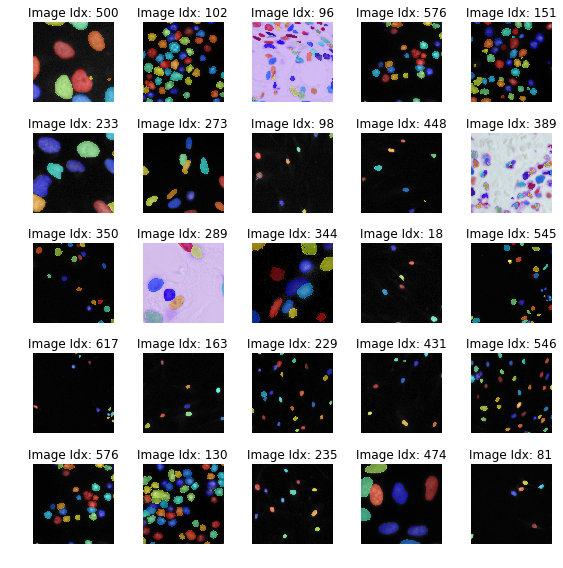

In [10]:
display_random_images(dataloader, 5,5)

In [ ]:
from skimage import color
from skimage import exposure
from sklearn.cluster import MiniBatchKMeans
import cv2

In [694]:
def onehot2label( labels ):
    #classe 0 back
    m,n,c = labels.shape
    mlabel = np.zeros( (m,n) )
    index = np.random.permutation(c)
    for i in range(c):
        mlabel += labels[:,:,i]*(index[i]+1)
    return mlabel

def quantized(imagein, k=5):

    h,w = imagein.shape[:2]
    image = cv2.cvtColor(imagein, cv2.COLOR_RGB2LAB)

    # reshape the image into a feature vector so that k-means
    # can be applied
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    # apply k-means using the specified number of clusters and
    # then create the quantized image based on the predictions
    clt = MiniBatchKMeans(n_clusters =  k )
    labels = clt.fit_predict(image)
    quant = clt.cluster_centers_.astype("uint8")[labels]

    # reshape the feature vectors to images
    quant = quant.reshape((h, w, 3))
    #image = image.reshape((h, w, 3))

    # convert from L*a*b* to RGB
    quant = cv2.cvtColor(quant, cv2.COLOR_LAB2RGB)
    #image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
    
    return quant
    
    

i: 129
0.547633766396 0.152366238618 0.0885576470588 0.751265098039
gamma:  0.5524988085625426
0.547633766396 0.152366238618 0.0885576470588 0.751265098039
129 (256, 320, 23)


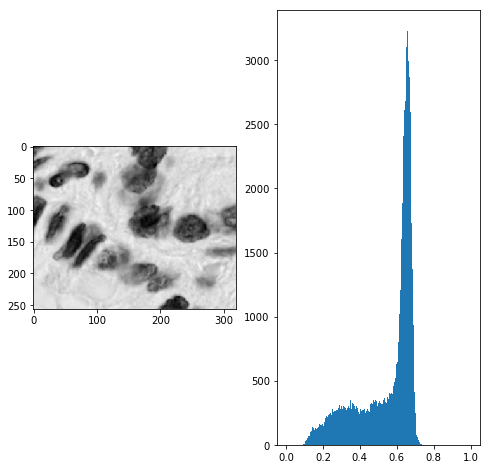

In [534]:
from skimage import color
from skimage import exposure
from sklearn.cluster import MiniBatchKMeans
import cv2

i=i+1
print('i:', i)

image, label = dataloader[ i ]
image = color.rgb2gray(image)
image = (image).astype( 'float' )

print(image.mean(),image.std(), image.min(), image.max() )

#gamma = 0.001 + (2.0-0.01)*np.random.rand()
#image = np.clip( image**gamma, 0,255 )
#image = image**gamma

print('gamma: ', gamma)

#image = cv2.equalizeHist(image)
image = image.astype('float')

mu=image.mean()
sigma = image.std()

#image = image - mu
#image = image / sigma

#image = image - image.min()
#image = image / image.max()
#image = image - 0.5

# Adaptive Equalization
#image = exposure.equalize_adapthist(image, clip_limit=0.03)

print(image.mean(),image.std(), image.min(), image.max() )
print(i,label.shape)
#imageshowlist( image, onehot2label(label) )

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.hist( image.ravel(), bins=256, range=(0.0, 1.0)) #fc='k', ec='k'
plt.show()


## Create Ground Truth

In [7]:
import skimage.morphology as morph
import scipy.ndimage as ndi
import skfmm

0.0 1.0 (256, 256)
0.0 1.0 (256, 256)
0.0 1.0 (256, 256)


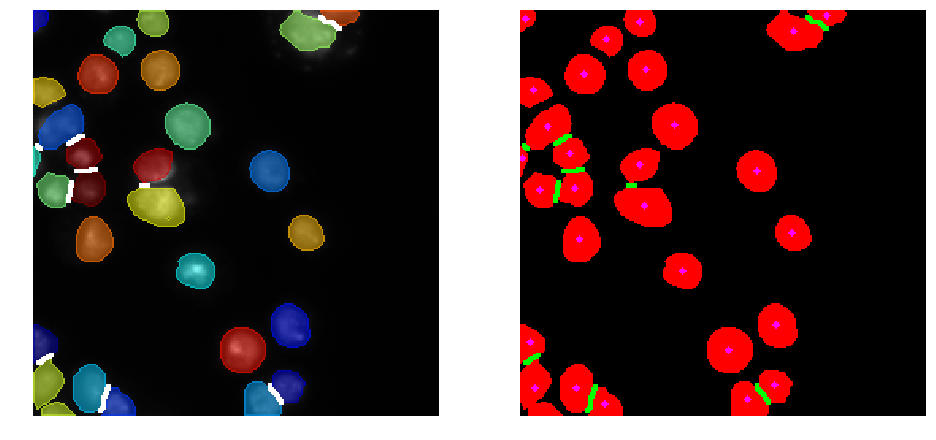

In [5]:
i=400
image, label = dataloader[ i ]
gtlabel = utl.create_groundtruth(label)

summary(gtlabel[:,:,0])
summary(gtlabel[:,:,1])
summary(gtlabel[:,:,2])

#plt.imshow(gtlabel, cmap='gray')
images = view.makeimagecell(image, label, alphaback=0.5, alphaedge=0.5)
y,x = np.where(gtlabel[:,:,1]==1)
images[y,x,:] = [1,1,1]
imageshowlist( images, gtlabel )

## Reshape Output

In [200]:
import math

def padding(data, fovnet , mode = 'mirror'):
    
    mH,mW = data.shape[:2]
    h,w = fovnet[:2]
    
    expand = False
    if len(data.shape) == 2:
        data = data[:,:,np.newaxis]
        expand = True

    cx = mW//w; padx = (w - mW%w)   
    cy = mH//h; pady = (h - mH%h)   
    border = pady, padx

    borderL = border[0]//2 
    borderR = np.ceil(border[0]/2).astype(np.uint8)     
    borderT = border[1]//2 
    borderB = np.ceil(border[1]/2).astype(np.uint8)
        
    paddedFullImage = np.zeros( (data.shape[0] + border[0], data.shape[1] + border[1], data.shape[2] ) );
    paddedFullImage[ borderL:(borderL+data.shape[0]), borderT:(borderT+data.shape[1]), : ] = data;
        
    if mode == 'mirror':
        
        xpadL  = borderL;
        xfromL = borderL+1;
        xtoL   = borderL+data.shape[0];    
        
        xpadR  = borderR;
        xfromR = borderR+1;
        xtoR   = borderR+data.shape[0];
        
        paddedFullImage[:xfromL,:,:] = paddedFullImage[ xfromL-1:xfromL+xpadL,:,:][::-1,:,:];
        paddedFullImage[xtoL:,:,:] = paddedFullImage[xtoL-xpadR:xtoL, :,:][::-1,:,:] ;

        ypadT  = borderT;
        yfromT = borderT+1;
        ytoT   = borderT+ data.shape[1];
        
        ypadB  = borderB;
        yfromB = borderB+1;
        ytoB   = borderB+ data.shape[1];
        
        paddedFullImage[:, :yfromT,:] = paddedFullImage[ :, yfromT-1:yfromT+ypadT,:][:,::-1,:];
        paddedFullImage[:, ytoT:,:] = paddedFullImage[ :, ytoT-ypadB:ytoT, :][:,::-1,:];
  
        
    if expand: paddedFullImage = paddedFullImage[:,:,0]   
    return paddedFullImage

# UNET RESIZE
def size_unet_transform(imagein, size=512, mode=None):
    
    height, width = imagein.shape[:2];
    image = np.array(imagein.copy())
    
    asp = float(height)/width
    w = size
    h = int(w*asp)

    #resize mantaining aspect ratio
    image_x = scipy.misc.imresize(image, (h,w), interp='bilinear', mode=mode)
    image = np.zeros((w,w))

    #crop image
    ini = int(round((w-h) / 2.0))
    image[ini:ini+h,:] = image_x

    #unet required input size
    downsampleFactor = 16;
    d4a_size   = 0;
    padInput   = (((d4a_size *2 +2 +2)*2 +2 +2)*2 +2 +2)*2 +2 +2;
    padOutput  = ((((d4a_size -2 -2)*2-2 -2)*2-2 -2)*2-2 -2)*2-2 -2;
    d4a_size   = math.ceil( (size - padOutput)/downsampleFactor);
    input_size = downsampleFactor*d4a_size + padInput;

    offset=(input_size-size)//2
    image_x = np.zeros((input_size,input_size));

    #crop for required size
    image_x[ offset:-offset, offset:-offset ] = image
    
    return image_x


0.0 1.0 (520, 696, 3)
0.0 0.956332862377 (572, 572)
0.0 1.0 (572, 572)
[ 1.4742268  1.4742268]


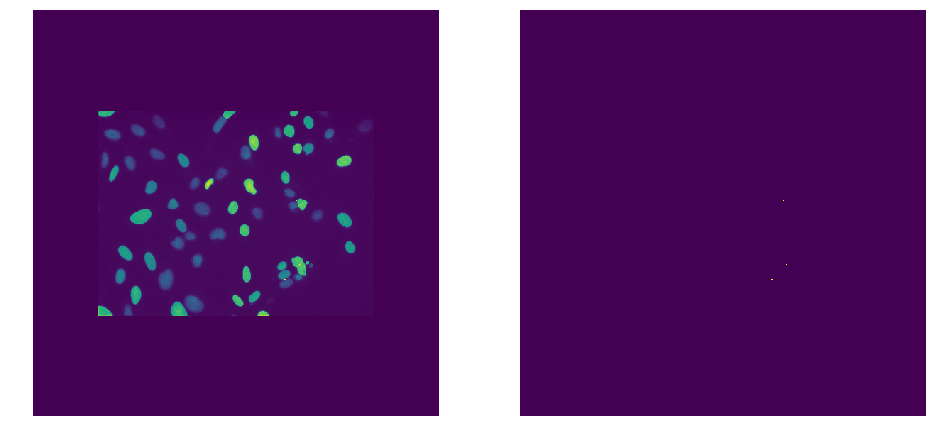

In [271]:

i=i+1 #376#21
image, label = dataloader[ i ]
image = view.makeimagecell(image, label, alphaback=0.5, alphaedge=0.9)
label = create_groundtruth(label)

summary(image)

label_pad = size_unet_transform( label[:,:,1] , 388, mode='F' )
image_pad = size_unet_transform( image[:,:,0] , 388, mode='F' )

summary(image_pad)
summary(label_pad)

imshape = image_pad.shape[:2]
print(np.array(imshape)/388)

y,x = np.where(label_pad[:,:]==1)
image_pad[y,x] = 1

imageshowlist( image_pad , label_pad[:,:]==1 )



# Random Crop 

In [165]:


def randomcrop(image, label, cropsize):
    
    h,w = image.shape[:2]
    new_h, new_w = cropsize
        
    top  = np.random.randint( h - new_h ) 
    left = np.random.randint( w - new_w ) 

    image = imagecrop( image, cropsize, top, left)
    label = imagecrop( label, cropsize, top, left)
    
    return image, label
    
    
def imagecrop( image, cropsize, top, left ):
    
    #if mult channel
    bchannel = False
    if len(image.shape) != 3:
        image = image[:,:,np.newaxis ]
        bchannel = True
    
    h, w, c = image.shape
    new_h, new_w = cropsize
    imagecrop = image[top:top + new_h, left:left + new_w, : ]
    
    if bchannel:
        imagecrop = imagecrop[:,:,0]
    
    return imagecrop


def delete_black_layer( masks ):
    
    newmasks = []
    for mask in masks:
        if mask.sum() != 0:
            newmasks.append(mask)    
            
    return newmasks


11 255 (256, 256, 3)
0.0 60.0 (256, 256, 60)
11 255 (250, 250, 3)
0.0 60.0 (250, 250, 60)
11 255 (250, 250, 3)
0.0 1.0 (250, 250, 3)


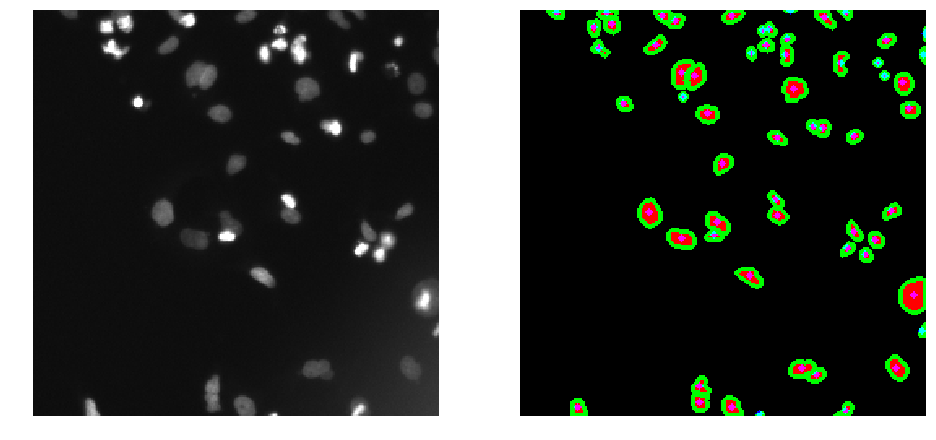

In [239]:
from scipy import ndimage

i=i+1 #21
image, label = dataloader[ i ]

summary(image)
summary(label)

image, label = randomcrop(image, label, (250,250) )
 

summary(image)
summary(label)


masks = (label.transpose((2,0,1))>0).astype(np.uint32)
masks = np.array([ ndimage.morphology.binary_fill_holes(x) for x in masks ])
masks = delete_black_layer(masks)

#image = view.makeimagecell(image, label, alphaback=0.5, alphaedge=0.9)
label = utl.create_groundtruth(masks)

summary(image)
summary(label)

imageshowlist( image , label )


## Image color tranformer

In [17]:
def normalize(data):
    tdata = data - np.min(data)
    tdata = tdata / np.max(data)
    return tdata

def showcolorchanel( image ):
    
    plt.figure( figsize=(18,18) )
    plt.subplot(131)
    plt.imshow(image[:,:,0], cmap='gray' )
    plt.subplot(132)
    plt.imshow(image[:,:,1], cmap='gray' )
    plt.subplot(133)
    plt.imshow(image[:,:,2], cmap='gray' )
    plt.show()

1 108 (256, 256, 3)


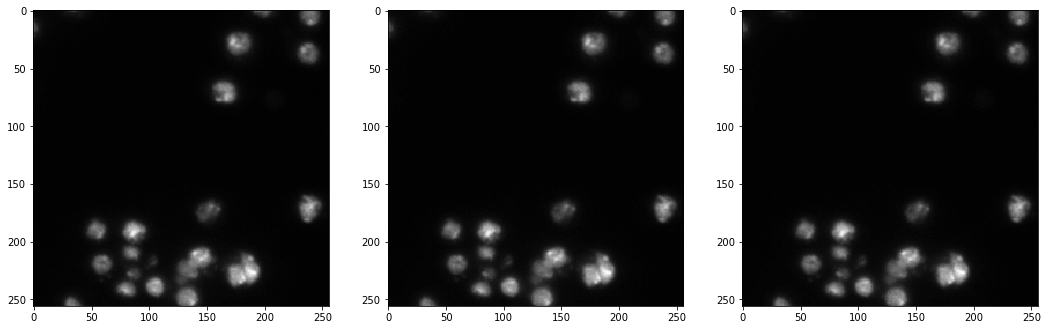

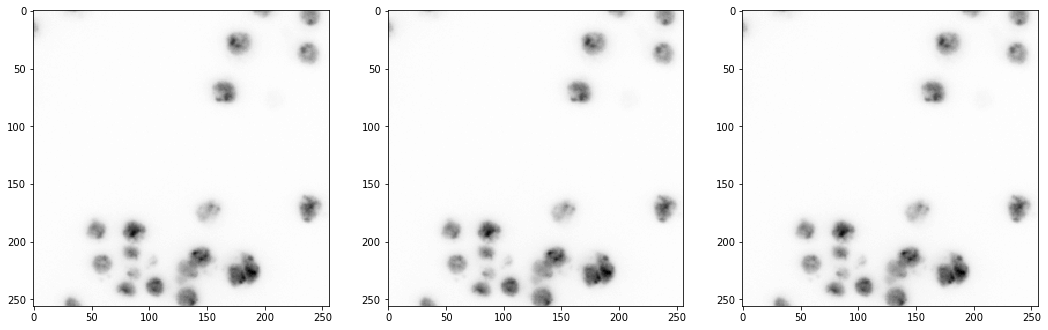

In [598]:
import cv2

i=0 # 376
image, label = dataloader[ i ]
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
ycb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

summary(image)
showcolorchanel( image )
showcolorchanel( 255-image )

#summary(hsv)
#showcolorchanel( hsv )
#summary(lab)
#showcolorchanel( lab )
#showcolorchanel( ycb )
#hly = ((normalize(lab)+normalize(hsv)+normalize(ycb))/3)*255
#showcolorchanel( hly )


# Create Weight Map

In [4]:
from deep.datasets import weightmaps 
from scipy import ndimage

In [6]:
def getweightmap(mask):
    
    w_c = np.empty(mask.shape)
    classes = np.unique(mask)
    frecs = [ np.sum(mask == i)/float(mask.size) for i in classes ] 
    
    print(frecs)
            
    # Calculate
    n = len(classes)
    for i in range( n ):
        w_c[mask == i] = 1 / (n*frecs[i])
    
    return w_c

def onehot2label( labels ):
    #classe 0 back
    m,n,c = labels.shape
    mlabel = np.zeros( (m,n) )
    for i in range(c):
        mlabel += labels[:,:,i]*(i+1)
    return mlabel
    


0.0 252.0 (512, 512)
0.0 255.0 (512, 512, 3)
0.42260569334 13.8692617416 (512, 512)


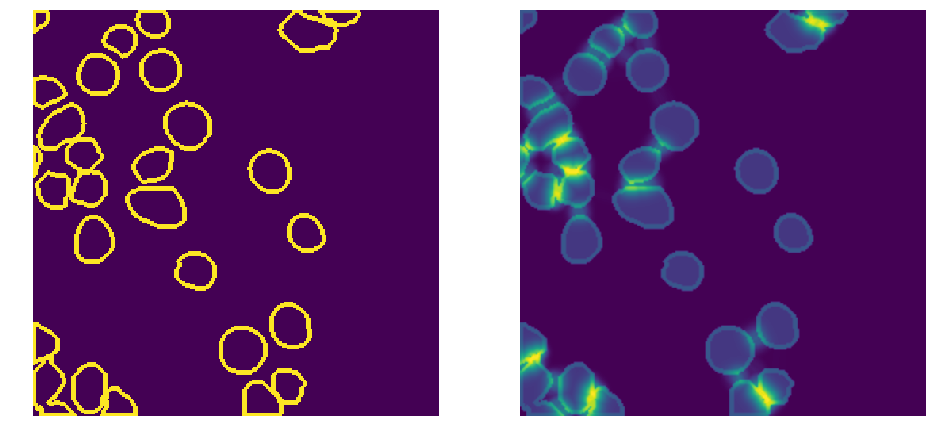

In [20]:
i=400
image, label = dataloader[ i ]
image_t, label_t, weight_t = prep.preprocessing(image, label)

summary(image_t)
summary(label_t)
summary(weight_t)

imageshowlist( label_t[:,:,1]>128, weight_t )


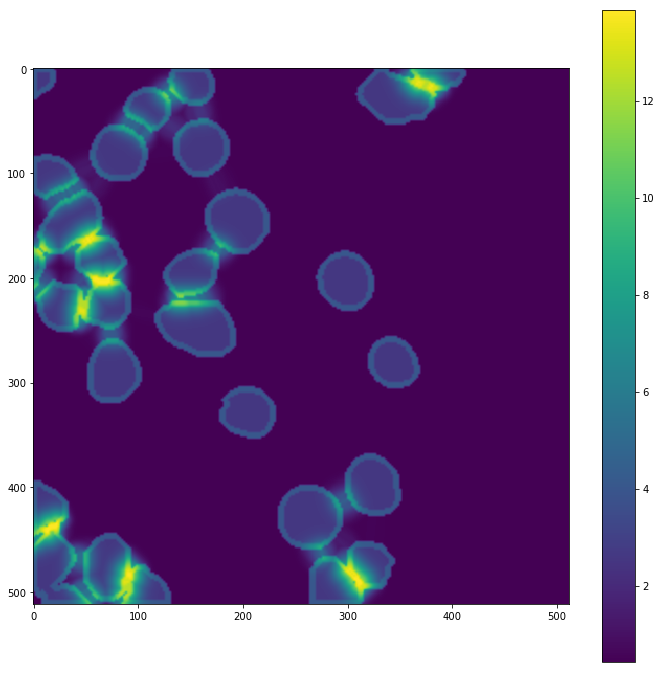

In [19]:

plt.figure( figsize=(12,12) )
plt.imshow( weight_t )
plt.colorbar()
plt.show()

